In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import derivative
import scipy.optimize as opt
import sympy as smp
from scipy.special import lambertw
import typing as tp

### Задача 1. Локализация корней.

Локализовать действительные корни в уравнении:

$$
f(x)=20 x^{3} - 4 x^{2} - 5 x + 1 .
$$

In [25]:
a = np.array([20, -4, -5, 1])
A = max(np.abs(a))
B = max(np.abs(a[1:]))
left = np.abs(a[-1]) / (np.abs(a[-1]) + B)
right = 1 + np.abs(A) / np.abs(a[0])
print(f"Положительные корни лежат в диапазоне от {round(left, 4)} до {round(right, 4)}")

Положительные корни лежат в диапазоне от 0.1667 до 2.0


In [20]:
x_s = smp.symbols("x")
eq = sum([a[i] * x_s**(3 - i) for i in range(len(a))])
eq

20*x**3 - 4*x**2 - 5*x + 1

In [21]:
smp.solve(eq)

[-1/2, 1/5, 1/2]

### Задача 4. Отделить корни следующих уравнений, а затем уточнить один из них с помощью подходящего итерационно процесса (любых двух на ваш выбор двумя разными методами).

Выберу уравнения 
$$
x 2^x=1
$$

$$
x^2-e^x / 5=0
$$

##### Аналитическое решение

Аналитическое решение может быть найдено при помощи библиотеки sympy.

In [3]:
x_s = smp.symbols("x")
eq_1 = x_s * (2 ** x_s) - 1
eq_2 = x_s**2 - smp.exp(x_s) / 5 

In [4]:
eq_1

2**x*x - 1

In [5]:
eq_2

x**2 - exp(x)/5

Аналитическое решение уравнения 1

In [6]:
smp.solve(eq_1, x_s)[0]

LambertW(log(2))/log(2)

Аналитическое решение уравнения 2

In [7]:
smp.solve(eq_2, x_s)[0]

-2*LambertW(-sqrt(5)/10)

In [8]:
smp.solve(eq_2, x_s)[1]

-2*LambertW(sqrt(5)/10)

In [9]:
smp.solve(eq_2, x_s)[2]

-2*LambertW(-sqrt(5)/10, -1)

Найдём численное значение полученных решений

In [10]:
eq_1_solutions = [lambertw(np.log(2)) / np.log(2)]
print("Аналитические решения уравнения 1", *eq_1_solutions)

Аналитические решения уравнения 1 (0.6411857445049859+0j)


In [11]:
eq_2_solutions = [-2 * lambertw(-np.sqrt(5) / 10), 
                  -2 * lambertw(np.sqrt(5) / 10),
                  -2 * lambertw(-np.sqrt(5) / 10, k = -1)]
print("Аналитические решения уравнения 2\n", *eq_2_solutions)

Аналитические решения уравнения 2
 (0.6052671213146187-0j) (-0.3714177524591739+0j) (4.7079379181288585-0j)


##### Метод Ньютона

In [12]:
def newton(z0, f, MAX_IT = int(1e4), eps = 1e-8):
    z, history = z0, []
    for _ in range(MAX_IT):
        history.append(z)
        dz = f(z)/derivative(f, z, dx = 1e-6)
        if abs(dz) < eps:
            return z
        z -= dz
    return -np.inf

f1 = lambda x: x * (2.0 ** x) - 1
f2 = lambda x: x**2 - np.exp(x) / 5
eq_1_numerical_solutions = []
eq_2_numerical_solutions = []
for z in np.arange(-20, 20, 0.5):
    eq_1_numerical_solutions.append(newton(z, f1))
    eq_2_numerical_solutions.append(newton(z, f2))

eq_2_numerical_solutions = np.array(eq_2_numerical_solutions)
eq_1_numerical_solutions = np.array(eq_1_numerical_solutions)

/tmp/ipykernel_7219/3379499873.py:5: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  dz = f(z)/derivative(f, z, dx = 1e-6)
/tmp/ipykernel_7219/3379499873.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  dz = f(z)/derivative(f, z, dx = 1e-6)
/home/vladimir/BOTAY!/ComputationalMathematics/.venv/lib/python3.10/site-packages/scipy/_lib/_finite_differences.py:144: RuntimeWarning: invalid value encountered in scalar multiply
  val += weights[k] * func(x0 + (k - ho) * dx, *args)


In [13]:
print("Решения уравнения 1 методом Ньютона\n", np.unique(eq_1_numerical_solutions.round(3)))
print("Решения уравнения 2 методом Ньютона\n", np.unique(eq_2_numerical_solutions.round(3)));

Решения уравнения 1 методом Ньютона
 [ -inf 0.641]
Решения уравнения 2 методом Ньютона
 [-0.371  0.605  4.708]


Как видим, решения полученные при помощи метода Ньютона совпали с аналитическими решениями.

##### Метод секущих

In [14]:
def secant_solver(f: tp.Callable,
                  x0_1: float,
                  x0_2: float,
                  MAX_ITER: int = int(1e4),
                  eps: float = 1e-1) -> float:
    """Нахождение корней функции f методом Ньютона

    Args:
        f (tp.Callable): Уравнение
        x0_1 (float): Начальное приближение 1
        x0_2 (float): Начальное приближение 2
        MAX_ITER (int, optional): Максимальное количество итераций. Defaults to int(1e3).
        eps (float, optional): Точность определения корней. Используется в условии остановки алгоритма. Defaults to 1e-3.
    """
    x_prev, x_prev_prev = x0_1, x0_2
    for n in range(MAX_ITER):
        x_new = x_prev_prev + f(x_prev_prev) * (x_prev - x_prev_prev) / (f(x_prev) - f(x_prev_prev))
        if np.abs(f(x_new)) < eps:
            return x_new
        x_prev_prev = x_prev
        x_prev = x_new
    return np.inf

In [15]:
eq_1_numerical_solutions = []
eq_2_numerical_solutions = []
for x_1 in np.arange(-20, 20, 1):
    for x_2 in np.arange(-20, 20, 1):
        eq_1_numerical_solutions.append(secant_solver(f1, x_1, x_2))
        eq_2_numerical_solutions.append(secant_solver(f2, x_1, x_2))

/tmp/ipykernel_7219/1151032529.py:17: RuntimeWarning: invalid value encountered in scalar divide
  x_new = x_prev_prev + f(x_prev_prev) * (x_prev - x_prev_prev) / (f(x_prev) - f(x_prev_prev))
/tmp/ipykernel_7219/3379499873.py:11: RuntimeWarning: overflow encountered in scalar power
  f1 = lambda x: x * (2.0 ** x) - 1
/tmp/ipykernel_7219/1151032529.py:17: RuntimeWarning: overflow encountered in scalar multiply
  x_new = x_prev_prev + f(x_prev_prev) * (x_prev - x_prev_prev) / (f(x_prev) - f(x_prev_prev))
/tmp/ipykernel_7219/3379499873.py:12: RuntimeWarning: overflow encountered in exp
  f2 = lambda x: x**2 - np.exp(x) / 5
/tmp/ipykernel_7219/3379499873.py:11: RuntimeWarning: overflow encountered in scalar multiply
  f1 = lambda x: x * (2.0 ** x) - 1
/tmp/ipykernel_7219/3379499873.py:12: RuntimeWarning: invalid value encountered in scalar subtract
  f2 = lambda x: x**2 - np.exp(x) / 5
/tmp/ipykernel_7219/1151032529.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  x_new

In [16]:
eq_1_numerical_solutions = np.array(eq_1_numerical_solutions)
eq_2_numerical_solutions = np.array(eq_2_numerical_solutions)
print("Корни уравнения 1 найденные методом секущих", np.unique(eq_1_numerical_solutions.round(2)))
print("Корни уравнения 2 найденные методом секущих", np.unique(eq_2_numerical_solutions.round(2)))

Корни уравнения 1 найденные методом секущих [inf]
Корни уравнения 2 найденные методом секущих [-0.3  -0.27 -0.26  0.61  0.64   inf]


### Задача 5. Зри в корень дважды

Вычислить с точностью $\varepsilon=10^{-3}$ координаты точек пересечения кривых (любых двух на ваш выбор двумя разными методами):

a)
$$
\left\{\begin{array}{l}
\sin (x+1)-y=1.2 \\
2 x+\cos (y)=2
\end{array}\right.
$$
B)
$$
\left\{\begin{array}{l}
\cos (x-1)+y=0.5 \\
x-\cos (y)=3
\end{array}\right.
$$

Алгоритм нахождения:
1. Из второго уравнения найдём как зависит $y(x)$. 
2. Подставим найденную зависимость в первое уравнение
3. Найдём корни полученного уравнения

Уравнение a:
$$
x = 1 - \operatorname{cos}(y) / 2 \\
\operatorname{sin}(2 - \operatorname{cos}(y) / 2) - y - 1.2 = 0 
$$

Уравнение в:
$$
x = 3 + \operatorname{cos}(y) \\
\operatorname{cos}(2 + \operatorname{cos}(y)) + y - 0.5 = 0
$$

In [17]:
y_eq_b = lambda y: np.cos(2 + np.cos(y)) + y - 0.5
y_eq_a = lambda y: np.sin(2 - np.cos(y) / 2) - y - 1.2
x_eq_a = lambda y: 1 - np.cos(y) / 2
x_eq_b = lambda y: 3 + np.cos(y)

In [32]:
eq_a_y_solutions, eq_b_y_solutions = [], []
for y0 in np.arange(-30, 30, 0.2):
    eq_a_y_solutions.append(newton(y0, y_eq_a)[0])
    eq_b_y_solutions.append(newton(y0, y_eq_b)[0])

/tmp/ipykernel_7219/1244499519.py:5: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  dz = f(z)/derivative(f, z, dx = 1e-6)


In [33]:
eq_a_y_solutions = np.unique(np.array(eq_a_y_solutions).round(4))
eq_b_y_solutions = np.unique(np.array(eq_b_y_solutions).round(4))
eq_a_x_solutions = x_eq_a(eq_a_y_solutions)
eq_b_x_solutions = x_eq_b(eq_b_y_solutions)
print(f"Уравнение 1 x = {eq_a_x_solutions}, y = {eq_a_y_solutions}")
print(f"Уравнение 2 x = {eq_b_x_solutions}, y = {eq_b_y_solutions}")

Уравнение 1 x = [0.51014631], y = [-0.2018]
Уравнение 2 x = [3.35591811], y = [1.2069]


### Задача 6*. Оценка скорости сходимости метода Ньютона.
Покажите, что для функции $f(x)=|x|^{5 / 2}$ метод Ньютона сходится лишь экспонциально - т.е. невязка уменьшается пропорционально $e^{-n}$.

Покажите аналитически, что метод Ньютона в лучшем случае имеет квадратичную экспонциальную сходимость, т.е. ошибка убывает пропорционально $e^{-n^2}$.

##### Эксперимент - сходиомсть метода Ньютона для функции $f(x) = |x|^{5/2}$

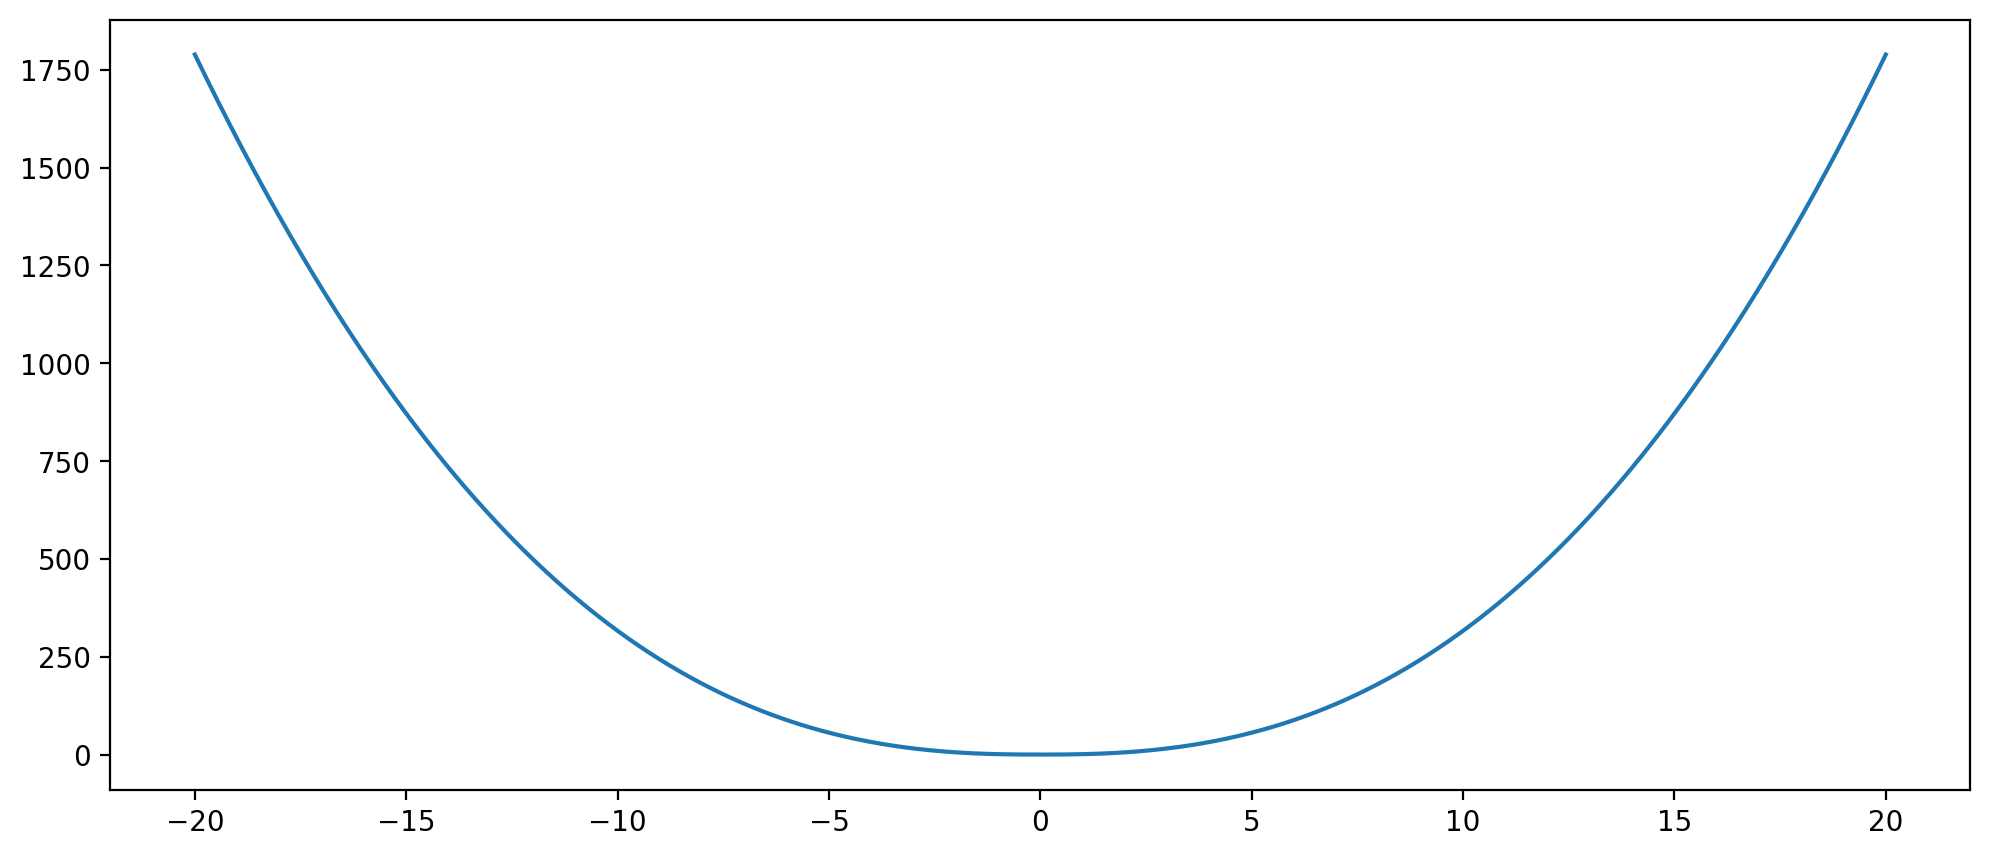

In [21]:
f = lambda x: np.power(np.abs(x), 5/2)
x_line = np.linspace(-20, 20, 1000)
plt.figure(figsize = (12, 5), dpi = 200)
plt.plot(x_line, f(x_line))

In [22]:
def newton(z0, f, MAX_IT = int(1e4), eps = 1e-8):
    z, history = z0, []
    for _ in range(MAX_IT):
        history.append(z)
        dz = f(z)/derivative(f, z, dx = 1e-6)
        if abs(dz) < eps:
            return z, history
        z -= dz
    return False

In [23]:
z, history = newton(20, f)
print(z)

7.909031990011839e-08


/tmp/ipykernel_7219/1244499519.py:5: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  dz = f(z)/derivative(f, z, dx = 1e-6)


/tmp/ipykernel_7219/3604826937.py:3: RuntimeWarning: overflow encountered in exp
  exp_prop = lambda x, a, b: a * np.exp(-x * b)


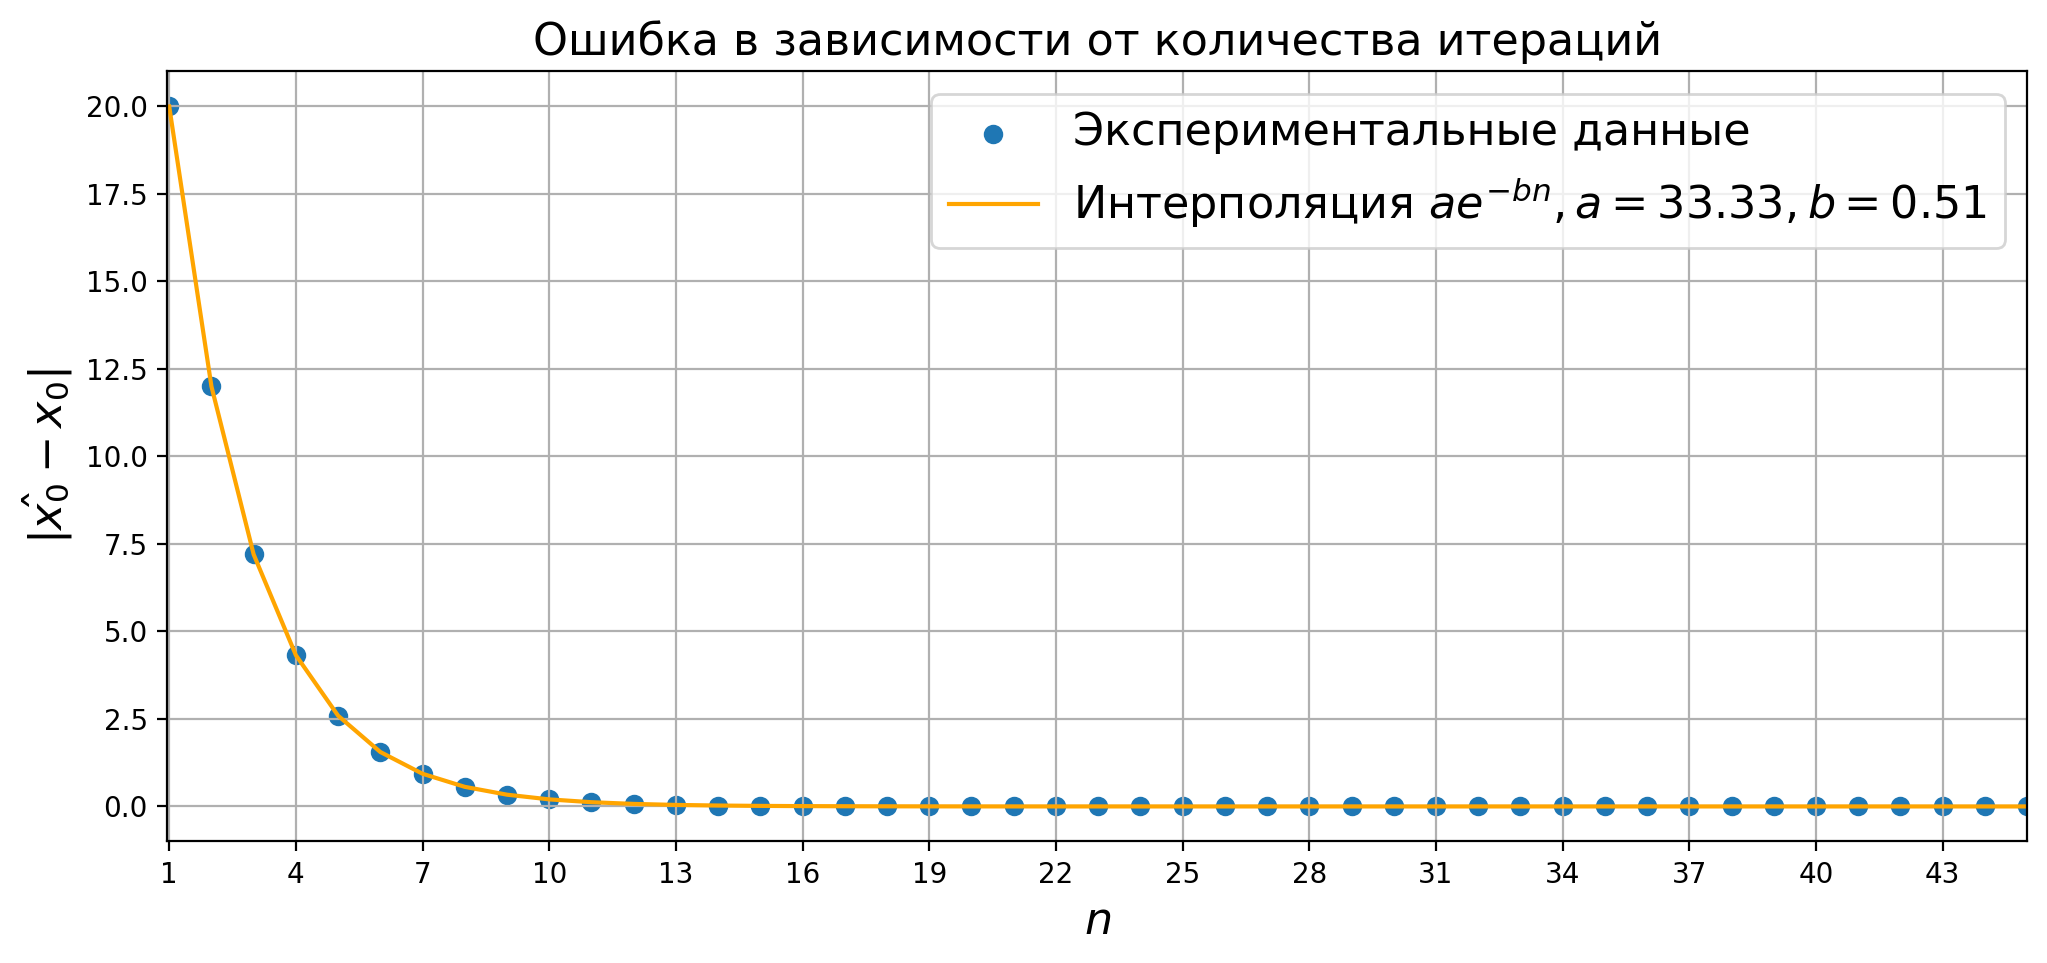

In [24]:
history = np.array(history)
iterations = np.arange(len(history)) + 1
exp_prop = lambda x, a, b: a * np.exp(-x * b)
param, _ = opt.curve_fit(exp_prop, iterations, history)

plt.figure(figsize = (12, 5), dpi = 200)
plt.scatter(iterations, history, label = 'Экспериментальные данные')
plt.plot(iterations, exp_prop(iterations, *param), label = 'Интерполяция $a e^{-b n},' + f'a = {param[0]:.2f}, b = {param[1]:.2f}$', color = 'orange')
plt.title("Ошибка в зависимости от количества итераций", fontsize = 16)
plt.xlabel("$n$", fontsize = 16)
plt.ylabel("$|\hat{x_{0}} - x_{0}|$", fontsize = 16)
plt.xticks(iterations[::3])
plt.legend(fontsize = 16)
plt.xlim(1 - 0.05, iterations[-1])
plt.grid()

##### Доказательство квадратичной экспоненциальной сходимости

Пусть $\eta$ - решение уравнения $f(x) = 0$.

Пусть на $n-ой$ итерации метода Ньютона приближение корня оказалось равным $x_{n}$.
Разложим функцию $f$ в окрестности $\eta$ по формуле Тейлора с остаточным членом в форме Лагранжа:
$$
0 = f(\eta) =  f(x_{n}) + f'(x_{n})(\eta - x_{n}) + \frac{f''(a)(\eta - x_{n})^{2}}{2}, \ a \in ( \eta, x_{n})
$$

Поделим это дело на $f'(x_{n}) \neq 0$

$$
0 = x_{n} - x_{n+1} + (\eta - x_{n}) + \frac{f''(a)(\eta - x_{n})^{2}}{2 \cdot f'(x_{n})} \to x_{n+1} - \eta  = \frac{f''(a)(\eta - x_{n})^{2}}{2 \cdot f'(x_{n})}
$$

В случае если исходное приближение корня $x_{0}$ <<хоршее>>, то $x_{n} \sim \eta$

$$
\frac{f''(a)}{2 \cdot f'(x_{n})} \sim \frac{f''(\eta)}{2 \cdot f'(\eta)} = \mathfrak{C} \to \frac{(x_{n+1} - \eta)}{(x_{n} - \eta)^{2}} = \frac{E_{n+1}}{E_{n}^{2}} \sim \mathfrak{C}
$$

При этом если $E_n = A exp(-n^{2}) \to E_{n+1} / E_{n}^{2} = exp(-(n+1)^{2}) / A exp(-2n^{2}) \sim C$ 